# Benchmarking mRNA's mRFP-expression

In this notebook, we apply seqme to mRNA sequences.

First install "helical" which contains the mRNA model.

In [ ]:
# !pip install helical

In [ ]:
%load_ext autoreload
%autoreload 2

import pickle
import subprocess
from collections.abc import Callable

import numpy as np
import pandas as pd
import torch
from helical.models.helix_mrna import HelixmRNA, HelixmRNAConfig
from sklearn.linear_model import LinearRegression

import seqme as sm

INFO:datasets:PyTorch version 2.6.0 available.


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"


## Data

Let's download the mRNA sequences.

In [ ]:
DATA_PATH = "mRFP_Expression.csv"

In [ ]:
DATA_URL = "https://raw.githubusercontent.com/Sanofi-Public/CodonBERT/refs/heads/master/benchmarks/CodonBERT/data/fine-tune/mRFP_Expression.csv"

wget_command = ["wget", "-O", DATA_PATH, DATA_URL]

try:
    subprocess.run(wget_command, check=True)
    print(f"File downloaded successfully as {DATA_PATH}")
except subprocess.CalledProcessError as e:
    print(f"Error occurred: {e}")

In [ ]:
dataset = pd.read_csv(DATA_PATH)

train_data = dataset[dataset["Split"] == "train"]
eval_data = dataset[dataset["Split"] == "val"]
test_data = dataset[dataset["Split"] == "test"]

In [ ]:
dataset.head()

,Sequence,Value,Dataset,Split
0,AUGGCAUCAUCAGAAGACGUCAUAAAAGAAUUUAUGCGAUUCAAAG...,10.164760,mRFP Expression,train
1,AUGGCGUCUUCAGAGGAUGUAAUCAAGGAAUUCAUGCGUUUUAAGG...,10.572869,mRFP Expression,train
2,AUGGCAUCAUCGGAAGAUGUAAUAAAGGAAUUUAUGCGUUUCAAAG...,9.766912,mRFP Expression,train
3,AUGGCGAGUAGUGAAGACGUUAUCAAAGAAUUUAUGCGUUUUAAGG...,9.926981,mRFP Expression,train
4,AUGGCUUCUUCUGAGGACGUAAUAAAGGAGUUCAUGAGGUUCAAGG...,9.857074,mRFP Expression,train


## Models

Let's define the models.

In [ ]:
class HelixmRNAModel:
    def __init__(self, max_length: int, batch_size: int, device: str):
        config = HelixmRNAConfig(
            batch_size=batch_size,
            max_length=max_length,
            device=device,
        )
        self.model = HelixmRNA(configurer=config)

    def __call__(self, sequences: list[str]) -> np.ndarray:
        return self.embed(sequences)

    def embed(self, sequences: list[str]) -> np.ndarray:
        with torch.inference_mode():
            dataset = self.model.process_data(sequences)
            token_embeddings = self.model.get_embeddings(dataset)
        return token_embeddings[:, -2, :]


class LinearRegressor:
    def __init__(self, embedder: Callable[[list[str]], np.ndarray]):
        self.embedder = embedder
        self.regressor = LinearRegression()

    def __call__(self, sequences: list[str]) -> np.ndarray:
        return self.predict(sequences)

    def predict(self, sequences: list[str]) -> np.ndarray:
        embeddings = self.embedder(sequences)
        return self.regressor.predict(embeddings)

    def fit(self, sequences: list[str], labels: np.ndarray):
        embeddings = self.embedder(sequences)
        self.regressor.fit(embeddings, labels)

In [ ]:
CACHE_PATH = "mrna_precomputed.pkl"

if CACHE_PATH is not None:
    with open(CACHE_PATH, "rb") as f:
        precomputed = pickle.load(f)
else:
    precomputed = None

cache = sm.ModelCache(init_cache=precomputed)

Lets setup the embedding model.

In [ ]:
batch_size = 8
max_length = max(len(s) for s in train_data["Sequence"]) + 10
rna_model = HelixmRNAModel(max_length=max_length, batch_size=batch_size, device=device)

cache.add("helix-mRNA", rna_model)
cache.add("RNA-fm", sm.models.RNA_FM(verbose=True))

INFO:helical.models.helix_mrna.model:Helix-mRNA initialized successfully.
INFO:helical.models.helix_mrna.model:'helical-ai/Helix-mRNA' model is in 'eval' mode, on device 'cpu'.


Lets setup a model predicting mRFP-expression (and train it).

In [ ]:
xs = train_data["Sequence"]
labels = train_data["Value"]

regressor = LinearRegressor(embedder=cache.model("RNA-fm"))
regressor.fit(xs, labels)

cache.add("regressor", regressor)

Let's look at an UMAP of the mRNA using helix-mRNA.

In [ ]:
seqs = list(train_data["Sequence"])
values = np.array(train_data["Value"])

xs = cache.model("RNA-fm")(seqs)

In [ ]:
xs_umap = sm.utils.umap(xs)

  warn(



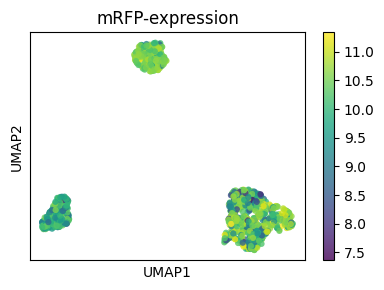

In [ ]:
sm.utils.plot_2d_embeddings(
    xs_umap,
    groups_or_values=values,
    title="mRFP-expression",
    xlabel="UMAP1",
    ylabel="UMAP2",
    alpha=0.8,
)

## Benchmark

Let's run the benchmark.

In [ ]:
mRFP_sequences = list(test_data["Sequence"])
mRFP_shuffled = sm.utils.shuffle_sequences(mRFP_sequences)

df = sm.compute_metrics(
    sequences={
        "mRFP": mRFP_sequences,
        "mRFP (permuted)": mRFP_shuffled,
    },
    metrics=[
        sm.metrics.ID(predictor=cache.model("regressor"), name="mRFP-expression", objective="maximize"),
        sm.metrics.Threshold(
            predictor=cache.model("regressor"),
            name="mRFP-expression (>10.5)",
            objective="maximize",
            threshold=10.5,
        ),
        sm.metrics.FKEA(embedder=cache.model("RNA-fm"), bandwidth=2.0),
    ],
)

100%|██████████| 6/6 [00:00<00:00, 20.93it/s, data=mRFP (permuted), metric=FKEA]                   


In [ ]:
sm.show_table(df)

,mRFP-expression↑,mRFP-expression (>10.5)↑,FKEA↑
mRFP,10.01±1.05,0.33,8.82
mRFP (permuted),-1.09±6.51,0.03,57.01


Let's save the cache to a file.

In [ ]:
with open(CACHE_PATH, "wb") as f:
    pickle.dump(cache.get(), f)